## 多层神经网络
在前面的线性回归中，我们的公式是 $y = w x + b$，而在 Logistic 回归中，公式是 $y = Sigmoid(w x + b)$，其实它们都可以看成单层神经网络，其中 Sigmoid 被称为激活函数，下面会详细介绍激活函数以及为什么必须使用激活函数。

### 理解神经网络
神经网络的灵感来自于人脑的神经元系统，下面我们放一张人脑的神经元和神经网络的对比图(来自 Stanford cs231n)

<img src="https://ws4.sinaimg.cn/large/006tNc79ly1fmgiz5mqs3j30or0773zg.jpg", width=800, heigth=400>

左边是一张神经元的图片，神经元通过突触接受输入，然后通过**神经激活**的方式传输给后面的神经元。这对比于右边的神经网络，首先接受数据输入，然后通过计算得到结果，接着经过**激活函数**，再传给第二层的神经元。

所以前面讲的 logistic 回归模型和线性回归模型都可以看做是一个单层神经网络，而 logistic 回归中使用了激活函数 sigmoid。

神经网络使用的激活函数都是非线性的，每个激活函数都输入一个值，然后做一种特定的数学运算得到一个结果，下面举几个例子

* sigmoid 激活函数

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

![](https://ws1.sinaimg.cn/large/006tNc79ly1fmgj7yto7gj308w05oa9w.jpg)

* tanh 激活函数

$$tanh(x) = 2 \sigma(2x) - 1$$

![](https://ws3.sinaimg.cn/large/006tNc79ly1fmgj8yjdnlj308w05mt8j.jpg)

* ReLU 激活函数

$$ReLU(x) = max(0, x)$$

![](https://ws1.sinaimg.cn/large/006tNc79ly1fmgj94ky2oj308n05uq2r.jpg)

关于 ReLU 激活函数，现在神经网络中 90% 的情况都使用它。一般一个一层的神经网络的公式就是 $y = max(0, w x + b)$，一个两层的神经网络就是 $y = w_2\ max(0, w_1 x + b_1) + b_2$，非常简单，但是却很有效，使用这个激活函数能够加快梯度下降法的收敛速度，同时对比与其他的激活函数，这个激活函数计算更加简单，所以现在变得非常流行。

### 全连接神经网络的结构
神经网络就是很多个神经元堆在一起形成一层神经网络，那么多个层堆叠在一起就是深层神经网络，我们可以通过下面的图展示一个两层的神经网络和三层的神经网络。

<img src="https://ws2.sinaimg.cn/large/006tNc79ly1fmgjiafmmjj30nu07075w.jpg", width=800, heigth=400>

可以看到，神经网络的结构其实非常简单，主要有输入层，隐藏层，输出层构成，输入层需要根据特征数目来决定，输出层根据解决的问题来决定，那么隐藏层的网路层数以及每层的神经元数就是可以调节的参数，而不同的层数和每层的参数对模型的结果都有一定的影响。

** 所谓的“全连接”就是指每一层所有的神经元都跟相邻层的神经元全部连接。**

### 为什么要使用激活函数
激活函数在神经网络中非常重要，使用激活函数也是非常必要的，前面我们从人脑神经元的角度理解了激活函数，因为神经元需要通过激活才能往后传播，所以神经网络中需要激活函数，下面我们从数学的角度理解一下激活函数的必要性。

比如一个两层的神经网络，使用 A 表示激活函数，那么

$$
y = w_2 A(w_1 x)
$$

如果我们不使用激活函数，那么神经网络的结果就是

$$
y = w_2 (w_1 x) = (w_2 w_1) x = \bar{w} x
$$

可以看到，我们将两层神经网络的参数合在一起，用 $\bar{w}$ 来表示，两层的神经网络其实就变成了一层神经网络，只不过参数变成了新的 $\bar{w}$，所以如果不使用激活函数，那么不管多少层的神经网络，$y = w_n \cdots w_2 w_1 x = \bar{w} x$，就都变成了单层神经网络，所以在每一层我们都必须使用激活函数。


### 案例
处理一个比较复杂的二分类问题，先用 Logistic 回归，再用神经网络

In [1]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

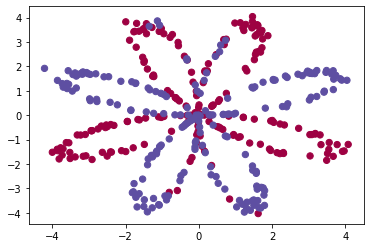

In [2]:
## 制造样本数据集
np.random.seed(1)
m = 400 # 样本数量
N = int(m/2) # 每一类的点的个数
D = 2 # 维度
x = np.zeros((m, D))
y = np.zeros((m, 1), dtype='uint8') # label 向量，0 表示红色，1 表示蓝色
a = 4

for j in range(2):
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40,cmap=plt.cm.Spectral)

* 我们的目的是将两种颜色的点分开，先测试 Logistic 回归的效果。

In [3]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

optimizer = torch.optim.SGD([w, b], 1e-1)

def logistic_regression(x):
    return torch.mm(x, w) + b

criterion = nn.BCEWithLogitsLoss()

In [4]:
for epoch in range(100):
    out = logistic_regression(Variable(x))
    loss = criterion(out, Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
        print('epoch: {}, loss: {}'.format(epoch+1, loss.item()))

epoch: 20, loss: 0.7545238733291626
epoch: 40, loss: 0.676191508769989
epoch: 60, loss: 0.6732147932052612
epoch: 80, loss: 0.6731476783752441
epoch: 100, loss: 0.6731461882591248


* 测试模型的预测表现

In [5]:
def plot_decision_boundary(model, x, y):
    # 确定输入数据的范围
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    h = 0.01
    
    # 产生网格点
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # 利用模型预测每个格点处的类别
    Z = model(np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)],axis=1))
    Z = Z.reshape(xx.shape)
    
    # 可视化（等势线为预测，散点为已知训练数据）
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40, cmap=plt.cm.Spectral)

    
def plot_logistic(x):
    x = Variable(torch.from_numpy(x).float())
    out = torch.sigmoid(logistic_regression(x))
    out = out > 0.5 
    return out.data.numpy()

Text(0.5, 1.0, 'logistic regression')

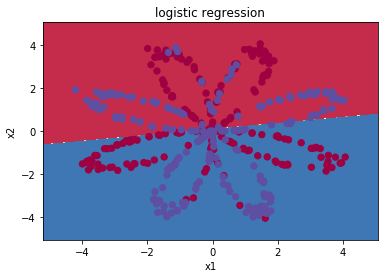

In [6]:
plot_decision_boundary(lambda x: plot_logistic(x), x.numpy(), y.numpy())
plt.title('logistic regression')

* **可以看到，Logistic 回归并不能很好的区分开这个复杂的数据集，那是因为 Logistic 回归是一个线性分类器。接下来测试非线性的分类器——神经网络**

In [7]:
# 定义两层神经网络的参数
w1 = nn.Parameter(torch.randn(2, 4) * 0.01) ## 隐层有4个神经元
b1 = nn.Parameter(torch.zeros(4))

w2 = nn.Parameter(torch.randn(4, 1) * 0.01)
b2 = nn.Parameter(torch.zeros(1))

# 定义模型
def two_layer_network(x):
    x1 = torch.mm(x, w1) + b1
    x1 = torch.tanh(x1) # 使用 PyTorch 自带的 tanh 激活函数
    x2 = torch.mm(x1, w2) + b2  # 输出层不做非线性变换了
    return x2

optimizer = torch.optim.SGD([w1, w2, b1, b2], 1.)

criterion = nn.BCEWithLogitsLoss()

In [8]:
# 模型训练 10000 次
for epoch in range(10000):
    out = two_layer_network(Variable(x))
    loss = criterion(out, Variable(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(epoch+1, loss.item()))

epoch: 1000, loss: 0.286414235830307
epoch: 2000, loss: 0.27312758564949036
epoch: 3000, loss: 0.26579588651657104
epoch: 4000, loss: 0.26021265983581543
epoch: 5000, loss: 0.2354818880558014
epoch: 6000, loss: 0.22602137923240662
epoch: 7000, loss: 0.22219318151474
epoch: 8000, loss: 0.21971595287322998
epoch: 9000, loss: 0.21784010529518127
epoch: 10000, loss: 0.21630960702896118


Text(0.5, 1.0, '2 layer network')

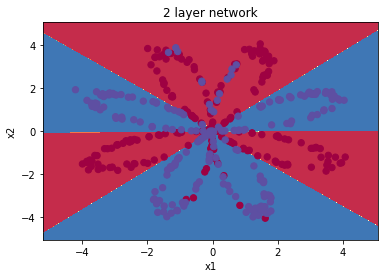

In [9]:
def plot_network(x):
    x = Variable(torch.from_numpy(x).float())
    x2 = two_layer_network(x)
    out = torch.sigmoid(x2)
    out = (out > 0.5)
    return out.data.numpy()

plot_decision_boundary(lambda x: plot_network(x), x.numpy(), y.numpy())
plt.title('2 layer network')

* 可以看到神经网络能够非常好地分类这个复杂的数据，和前面的 logistic 回归相比，神经网络因为有了激活函数的存在，成了一个非线性分类器，所以神经网络分类的边界更加复杂。

## 两种搭建深度网络的方式
以上搭建神经网络是自行定义参数，然后靠手动矩阵相乘实现的，这对简单的网络没问题，但是对于非常深的网络（比如100层），这种做法就非常低效，也容易出错。所以 PyTorch 提供了两个模块来帮助我们构建模型，一个是 Sequential，一个是 Module。

Sequential 允许我们构建序列化的模块，而 Module 是一种更加灵活的模型定义方式，接下来分别用 Sequential 和 Module 来重新定义上面的神经网络。

### 用 nn.Sequential 搭建模型

In [10]:
# Sequential
seq_net = nn.Sequential(
    nn.Linear(2, 4), # PyTorch 中的线性层，wx + b
    nn.Tanh(),   # 激活函数
    nn.Linear(4, 1) # 输出层 
)

In [11]:
# 序列模块可以通过索引访问每一层

seq_net[0] # 第一层

Linear(in_features=2, out_features=4, bias=True)

In [12]:
# 打印出第一层的权重（初始权重）

w0 = seq_net[0].weight
print(w0)

Parameter containing:
tensor([[ 0.1147,  0.4734],
        [-0.1869,  0.0093],
        [ 0.2745,  0.1050],
        [ 0.0038, -0.3479]], requires_grad=True)


In [13]:
# 通过 parameters 可以取得模型的参数
param = seq_net.parameters()

# 定义优化器
optim = torch.optim.SGD(param, 1.)

In [14]:
# 我们训练 10000 次
for epoch in range(10000):
    out = seq_net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (epoch + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(epoch+1, loss.item()))

epoch: 1000, loss: 0.28468942642211914
epoch: 2000, loss: 0.2720593512058258
epoch: 3000, loss: 0.2649850845336914
epoch: 4000, loss: 0.2601870000362396
epoch: 5000, loss: 0.2567650377750397
epoch: 6000, loss: 0.2542324364185333
epoch: 7000, loss: 0.252297043800354
epoch: 8000, loss: 0.25077754259109497
epoch: 9000, loss: 0.24955736100673676
epoch: 10000, loss: 0.24855852127075195


In [15]:
def plot_seq(x):
    out = torch.sigmoid(seq_net(Variable(torch.from_numpy(x).float()))).data.numpy()
    out = (out > 0.5) 
    return out

Text(0.5, 1.0, 'sequential')

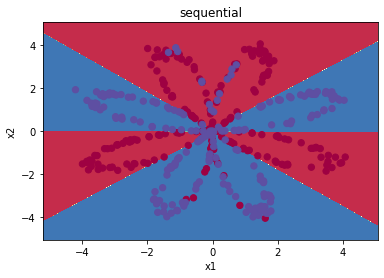

In [16]:
plot_decision_boundary(lambda x: plot_seq(x), x.numpy(), y.numpy())
plt.title('sequential')

### 保存模型
保存模型在 PyTorch 中有两种方式，一种是将模型结构和参数都保存在一起，一种是只将参数保存下来。

#### 参数和模型保存在一起

In [18]:
torch.save(seq_net, 'save_seq_net.pth')

# torch.save里面有两个参数，第一个是要保存的模型，第二个参数是保存的路径

C:\Users\zq\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\zq\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\zq\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [19]:
# 读取保存的模型
seq_net1 = torch.load('save_seq_net.pth')

In [20]:
seq_net1

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [21]:
print(seq_net1[0].weight)

Parameter containing:
tensor([[ 10.0487,  11.7529],
        [  0.0445,   7.9359],
        [  0.5535,   1.9938],
        [ 10.3003, -12.9079]], requires_grad=True)


可以看到我们重新读入了模型，并且将其命名为 seq_net1，并且打印了第一层的参数

#### 只保存参数，而不保存模型结构

In [22]:
# 保存模型参数
torch.save(seq_net.state_dict(), 'save_seq_net_params.pth')

如果要重新读入模型的参数，首先我们需要重新定义一次模型，接着重新读入参数

In [24]:
seq_net2 = nn.Sequential(
    nn.Linear(2, 4),
    nn.Tanh(),
    nn.Linear(4, 1)
)

seq_net2.load_state_dict(torch.load('save_seq_net_params.pth'))
print(seq_net2)
print(seq_net2[0].weight)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)
Parameter containing:
tensor([[ 10.0487,  11.7529],
        [  0.0445,   7.9359],
        [  0.5535,   1.9938],
        [ 10.3003, -12.9079]], requires_grad=True)


* 可以发现两种方式的结果是一样的。一般而言，**推荐第二种保存模型的方式**，因为可移植性更强。

### 用 nn.Module 搭建模型
用 nn.Module 搭建神经网络的模板如下

```
class 网络名字(nn.Module):
    def __init__(self, 一些定义的参数):
        super(网络名字, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        self.layer2 = nn.Sequential(...)
        ...
        
        定义需要用的网络层
        
    def forward(self, x): # 定义前向传播
        x1 = self.layer1(x)
        x2 = self.layer2(x)
        x = x1 + x2
        ...
        return x
```

注意的是，Module 里面也可以使用 Sequential，同时 Module 非常灵活，具体体现在 forward 中，如何复杂的操作都能直观的在 forward 里面执行。

我们将上面 nn.Sequential() 搭建的模型再用 nn.Module() 搭建一遍

In [25]:
class module_net(nn.Module):
    def __init__(self, num_input, num_hidden, num_output):
        super(module_net, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        
        self.layer2 = nn.Tanh()
        
        self.layer3 = nn.Linear(num_hidden, num_output)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [26]:
mo_net = module_net(2, 4, 1)

In [27]:
# 访问模型中的某层可以直接通过名字

# 第一层
l1 = mo_net.layer1
print(l1)

# 打印出第一层的权重
print(l1.weight)

Linear(in_features=2, out_features=4, bias=True)
Parameter containing:
tensor([[-0.5713,  0.1837],
        [ 0.4268,  0.6124],
        [ 0.5515, -0.2001],
        [-0.2982,  0.0157]], requires_grad=True)


In [28]:
# 定义优化器
optim = torch.optim.SGD(mo_net.parameters(), 1.)

In [30]:
# 我们训练 10000 次
for epoch in range(10000):
    out = mo_net(Variable(x))
    loss = criterion(out, Variable(y))
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (epoch + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(epoch+1, loss.item()))

epoch: 1000, loss: 0.24586492776870728
epoch: 2000, loss: 0.23487813770771027
epoch: 3000, loss: 0.22888566553592682
epoch: 4000, loss: 0.224856436252594
epoch: 5000, loss: 0.22187796235084534
epoch: 6000, loss: 0.21955087780952454
epoch: 7000, loss: 0.2176722288131714
epoch: 8000, loss: 0.2161267250776291
epoch: 9000, loss: 0.214837908744812
epoch: 10000, loss: 0.2137501835823059


In [31]:
# 保存模型
torch.save(mo_net.state_dict(), 'module_net.pth')

可以发现用 Sequential 或者 Module 来搭建模型还是很方便的。